I am going to replicate a machine learning paper and turn it into a usable code.

## Vision Transformer (ViT) architecture
source : https://arxiv.org/pdf/2010.11929v2.pdf

In [1]:
'''
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
'''

'\ntry:\n    import torch\n    import torchvision\n    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"\n    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"\n    print(f"torch version: {torch.__version__}")\n    print(f"torchvision version: {torchvision.__version__}")\nexcept:\n    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")\n    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113\n    import torch\n    import torchvision\n    print(f"torch version: {torch.__version__}")\n    print(f"torchvision version: {torchvision.__version__}")\n'

In [2]:
# Import required libraries and code
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt

In [3]:
# regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
    print("Import successfull")
except:
    # Get the going_modular scripts
    # Clones github repo
    # moves specified directory to root with '.'
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/aayush2058/pytorch_fundamentals
    !move pytorch_fundamentals/going_modular .

Import successfull


In [4]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

Getting foodvision data (pizza, steak, sushi)

In [5]:
from helper_functions import download_data

image_path = download_data(source = "https://github.com/aayush2058/pytorch_fundamentals/raw/main/data/pizza_steak_sushi.zip",
                           destination = "pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [6]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

### Create Datasets and Dataloaders

In [7]:
from going_modular import data_setup

# Create image size
IMG_SIZE = 224 #from the table 3 of ViT paper

# Create transforms pipeline
manual_transforms = transforms.Compose([
                                       transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                       transforms.ToTensor()
                                       ])

print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [8]:
# Create a batch size of 32 (the paper uses 4096 which may be too big for smaller hardware....can always scale up later)
BATCH_SIZE = 32

# Create DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                              test_dir = test_dir,
                                                                              train_transform = manual_transforms,
                                                                              test_transform = manual_transforms,
                                                                              batch_size = BATCH_SIZE)
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

#### Visualize a single image

In [9]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# View the single image and label shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

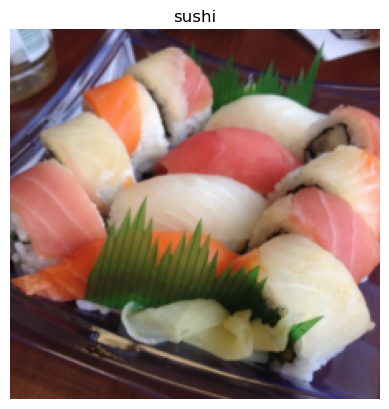

In [10]:
# Plot the image with matplotlib

plt.imshow(image.permute(1, 2, 0)) # C, H, W
plt.title(class_names[label])
plt.axis(False);

###### -------------------------------------------------------------------------

## Replicating ViT : Overview

Looking at a whole machine learning research paper can be intimidating.

So in order to make it more understandable, we can break it down into smaller pieces:

* **Inputs** - What goes into the model? (in our case, image tensors)
* **Outputs** - What comes out of the model/layer/block? (in our case, we want the model to output image classification labels)
* **Layers** - Takes an input, manupulates it with a function (for example could be self-attention).
* **Blocks** - A collection of layers.
* **Model** - A collection of blocks.

### ViT overview pieces of the puzzle

* Figure : Visual overview of the architecture
* Four equations : math equations which define the functions of each layer/block
* Table / : different hyperparameters for architecture/training.
* Text

#### Figure 1
![](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-figure-1-architecture-overview.png)

* Embeddings = learnable representation (start with random numbers and improve over time)

#### Four equations
![](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-four-equations.png)

###### 3.1 Vision TRANSFORMER (VIT) (describes the various equations):

**Equation 1:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

**Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

**Equation 4:**
Similar to BERT's [class] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_0^0=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_L^0\right)$ serves as the image representation $\mathbf{y}$ (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.



**Equation 2&3:**
The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

#### Table 1
![](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-table-1.png)

* ViT-Base, ViT-Large and ViT-Huge are all different sizes of the same model architecture.
* Layers - the number of transformer encoder layers.
* Hidden size $D$ - the embedding size throughout the architecture.
* MLP size  - the number of hidden units/neurons in the MLP.
* Heads - the number of multi-head self-attention.

## Equation 1: Split data into patches and create the class, position and patch embedding

Layers = input -> function -> output


In [11]:
# Create exmale values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

In [12]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape}")
      

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768)


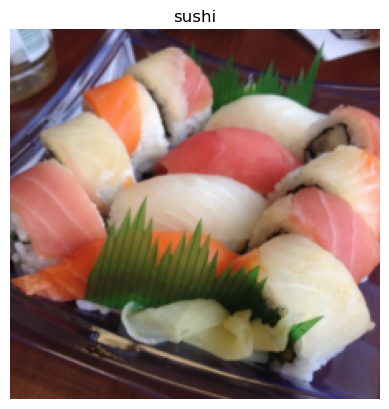

In [13]:
# View a single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

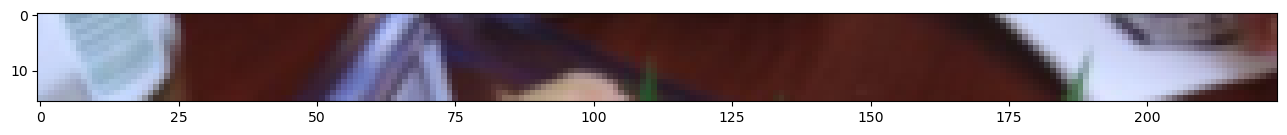

In [14]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize = (patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, : , : ])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


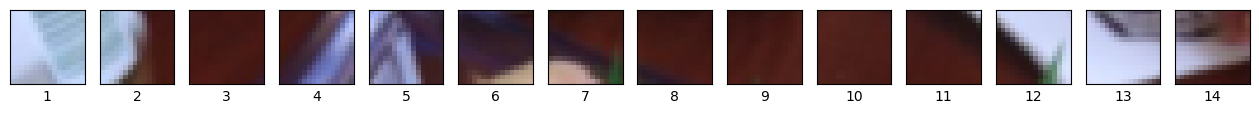

In [15]:
# Setup code to plot top row
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows = 1,
                       ncols = img_size // patch_size, # one column for each patch
                       sharex = True,
                       sharey = True,
                       figsize = (patch_size, patch_size)
                       )

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch + patch_size, :]);
    axs[i].set_xlabel(i+1) # Set the patch label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0    
Number of patches per column: 14.0    
Total patches: 196.0    
Patch size: 16 pixels x 16 pixels


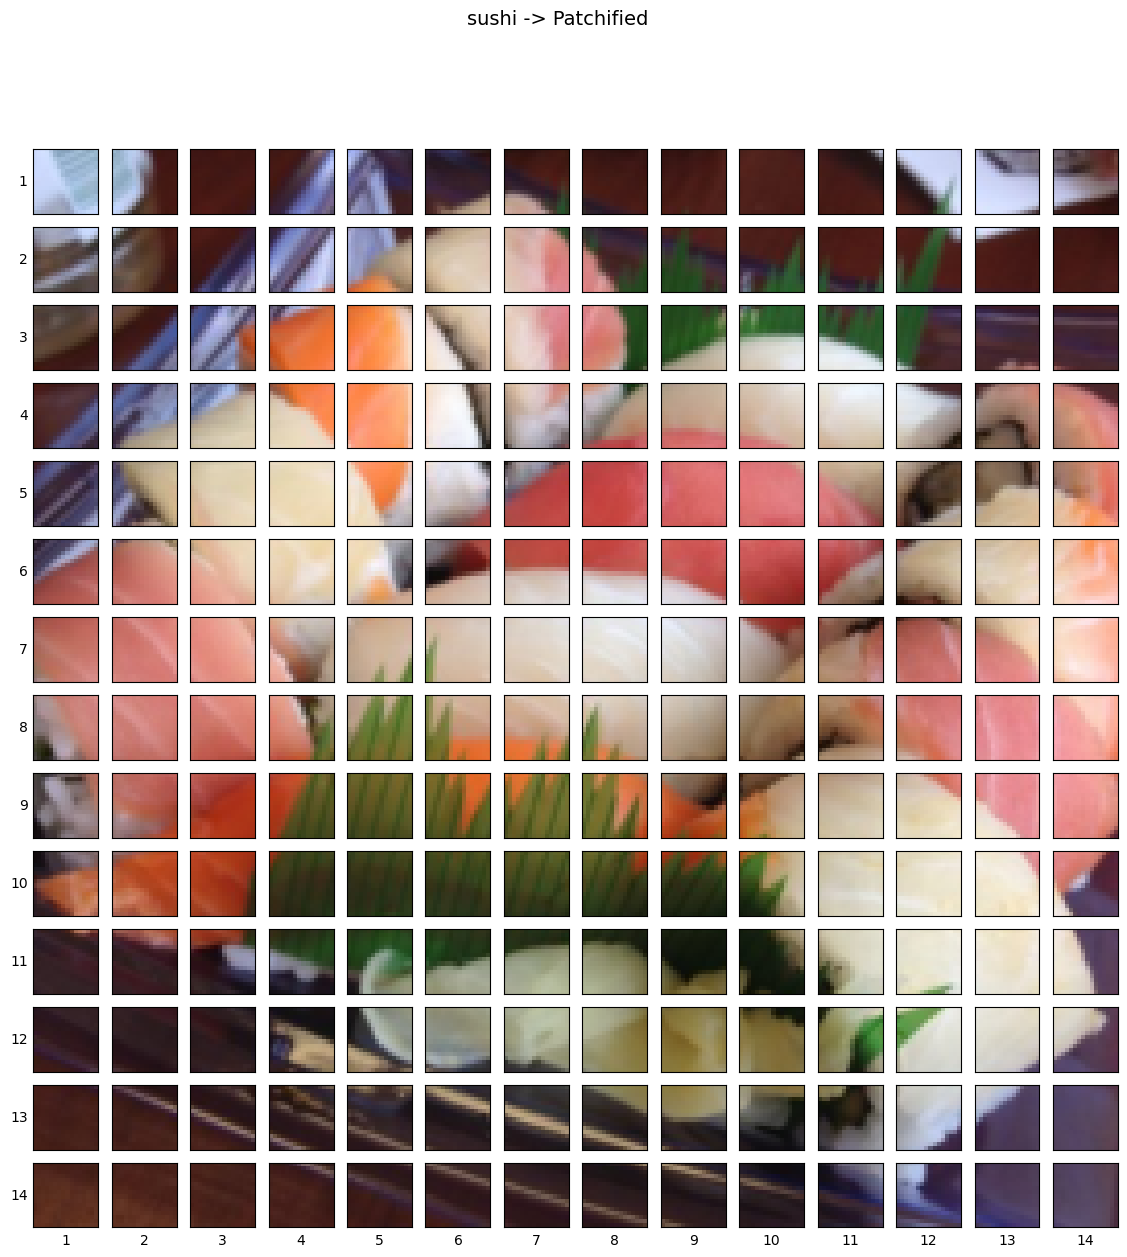

In [16]:
# Setup code to plot whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
    \nNumber of patches per column: {num_patches}\
    \nTotal patches: {num_patches*num_patches}\
    \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows = img_size // patch_size,
                       ncols = img_size // patch_size,
                       figsize = (num_patches, num_patches),
                       sharex = True,
                       sharey = True
                       )

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width
        # Plot the permuted image on the different axes
        axs[i, j].imshow(image_permuted[patch_height:patch_height + patch_size, # iterate through height
                                       patch_width:patch_width + patch_size, # iterate through width
                                        : ])
        # Setup label information for each subplot (patch)
        axs[i, j].set_ylabel(i+1,
                            rotation = "horizontal",
                            horizontalalignment = "right",
                            verticalalignment = "center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()
        
# Setup a title for the plot
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize = 14)
plt.show()


### Creating image patches and turning them into patch embeddings

In [17]:
# Creating conv2d layer to turn image into patches of learnable feature maps (embeddings)
from torch import nn

# Set the patch size
patch_size = 16

# Create a conv2d layer with hyperparameters from the VIT paper
conv2d = nn.Conv2d(in_channels = 3, # for colour images
                  out_channels = 768, # D size from Table 1 for ViT base
                  kernel_size = patch_size,
                   stride = patch_size,
                   padding = 0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

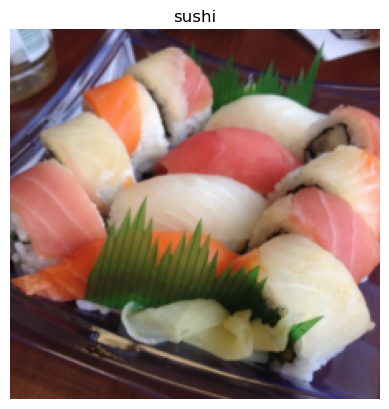

In [18]:
# View single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [19]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension -> (batch_size, color_channels, height, width)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


##### After passing a single image to `conv2d` layer, it's shape is:

torch.size([1, 768, 14, 14]) - (batch_size, embedding_dim, feature_map_height, feature map width)

In [20]:
image_out_of_conv.requires_grad

True

Showing random convolutional feature maps from indexes: [85, 72, 269, 442, 272]


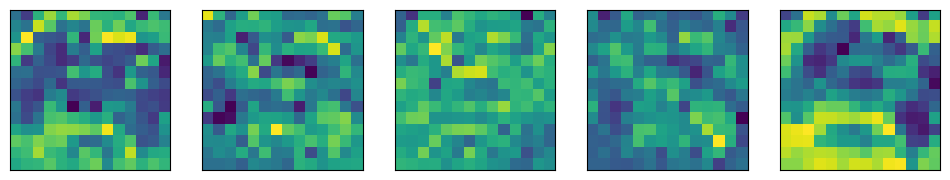

In [21]:
# Plot random convolutional feature maps (embeddings)
import random
random_indexes = random.sample(range(0, 758), k = 5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows = 1, ncols = 5, figsize = (12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[ : , idx, : , : ] # index on the output tensor of the conv2d layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # remove batch dimension, and remove from grad tracking/switch to numpy for matplotlib
    axs[i].set(xticklabels = [], yticklabels = [], xticks = [], yticks = [])

In [22]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[ : , 0, : , :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 0.0735,  0.1350,  0.0917, -0.1076, -0.1341, -0.1332, -0.1324,
            0.0774,  0.0722,  0.1151,  0.1125,  0.6272, -0.3009,  0.2804],
          [ 0.2678,  0.1076, -0.1953, -0.1222,  0.1119,  0.2153,  0.1567,
           -0.1079,  0.0797, -0.0096,  0.0776,  0.2181,  0.1492,  0.0686],
          [ 0.2565, -0.2563,  0.2691,  0.3392,  0.2918,  0.3088,  0.2982,
            0.0265, -0.4170, -0.4463, -0.4565,  0.0340,  0.0864,  0.0517],
          [-0.0785, -0.0237, -0.0350,  0.1026,  0.3733,  0.1387,  0.3782,
            0.1696,  0.3478,  0.3525,  0.4011,  0.2025,  0.3274,  0.0621],
          [-0.0713,  0.4937,  0.2587,  0.2848,  0.0656,  0.5441,  0.2764,
            0.3019,  0.3663,  0.3402,  0.3767, -0.0406, -0.0928,  0.3496],
          [ 0.2592,  0.2552,  0.3484,  0.3304,  0.4419, -0.3720, -0.0364,
           -0.0563,  0.1717,  0.4215,  0.1934,  0.4440,  0.2419,  0.3069],
          [ 0.1903,  0.3344,  0.3634,  0.4728,  0.3141,  0.2959,  0.2826,
            0.2951,  0.2868, -0.

##### Flattening the patch embedding with 'torch.nn.Flatten' 

* to satisfy the input criteria of ViT Encoder

In [23]:
print(f"{image_out_of_conv.shape} -> (batch size, embedding dim, feature map height, feature map width)")

torch.Size([1, 768, 14, 14]) -> (batch size, embedding dim, feature map height, feature map width)


Want: (batch size, number of patches, embedding dim)

In [24]:
from torch import nn
flatten_layer = nn.Flatten(start_dim = 2,  # [0:1, 1:768, 2:14, 3:14]
                          end_dim = 3)
flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

##### Putting everything together

Original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


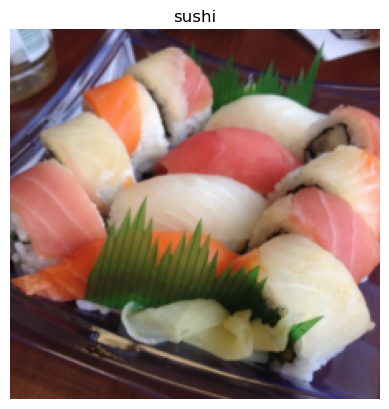

In [25]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension
print(f"Image feature map (patches) shape: {image_out_of_conv.shape}")

# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [26]:
# Rearrange output of flattened layer
image_out_of_conv_flattened.permute(0, 2, 1).shape # Batch_size, number_of_patches, embedding_dimensions

torch.Size([1, 196, 768])

(-0.5, 195.5, 0.5, -0.5)

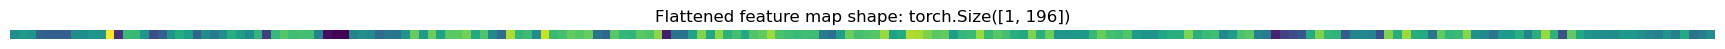

In [27]:
# Get a single flattened feature map
# getting only one embedding dimension [0th index]
single_flattened_feature_map = image_out_of_conv_flattened.permute(0, 2, 1)[ : , : ,0]
single_flattened_feature_map

# Plot the flattened map visually
plt.figure(figsize = (22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)

### Turning the ViT patch embedding layer into a PyTorch module

Making sure to:
1. Create a class called `PatchEmbedding` that inherits from `nn.Module`.
2. Initialize with appropriate hyperparameters, such as channels, embedding dimension, patch size.
3. Create a layer to turn as image into embedding patches using `nn.Conv2d()`.
4. Create a layer to flatten the feature maps of the output of the layer in 3.
5. Define a `forward()` that defines the forward computation (e.g. pass through layer from 3 and 4).
6. Make sure the output shape of the layer reflects the required output shape of the patch embedding.

In [28]:
# 1.
class PatchEmbedding(nn.Module):
    
    # 2.
    def __init__(self, 
                 in_channels: int = 3,
                 patch_size: int = 16,
                 embedding_dim: int = 768): # from table 1 for ViT-Base
        super().__init__()
        
        # 3.
        self.patcher = nn.Conv2d(in_channels = in_channels,
                                 out_channels = embedding_dim,
                                 kernel_size = patch_size,
                                 stride = patch_size,
                                 padding = 0)
        
        # 4.
        self.flatten = nn.Flatten(start_dim = 2,
                                        end_dim = 3)
    # 5.    
    def forward(self, x):
        # Create assertion to check that inputs are correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"
        
        # Perform fordward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        
        # 6. dimensions to be -> [batch_size, no_of_patches, embedding_dimension]
        return x_flattened.permute(0, 2, 1)

In [29]:
# Setting seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Creating an instance of patch embedding
patchify = PatchEmbedding(in_channels = 3,
                         patch_size = 16,
                         embedding_dim = 768)

# Pass a single image through patch embedding layer
print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension
print(f"Output patch embedding sequence shape: {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])


### Creating the class token embedding

Want to: prepend a learnable class token to the start of the patch embedding

In [30]:
patch_embedded_image

tensor([[[-0.8165,  0.1900, -0.2495,  ...,  0.5122, -0.3174,  0.3793],
         [-0.4341, -0.1945, -0.1191,  ...,  0.2445, -0.2315,  0.3959],
         [-0.1952, -0.0192, -0.0389,  ...,  0.0870, -0.0926,  0.0757],
         ...,
         [-0.2213, -0.0229, -0.1058,  ...,  0.3601, -0.2043,  0.2446],
         [-0.3170,  0.0923, -0.1264,  ...,  0.2482, -0.1220,  0.0680],
         [-0.3282,  0.0589, -0.1235,  ...,  0.2696, -0.1551,  0.0933]]],
       grad_fn=<PermuteBackward0>)

In [31]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [32]:
# Create class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                          requires_grad = True)

class_token.shape

torch.Size([1, 1, 768])

In [33]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [34]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                     dim = 1) # number_of_patches dimension
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> (batch_size, class_token + number_of_batches)")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.8165,  0.1900, -0.2495,  ...,  0.5122, -0.3174,  0.3793],
         [-0.4341, -0.1945, -0.1191,  ...,  0.2445, -0.2315,  0.3959],
         ...,
         [-0.2213, -0.0229, -0.1058,  ...,  0.3601, -0.2043,  0.2446],
         [-0.3170,  0.0923, -0.1264,  ...,  0.2482, -0.1220,  0.0680],
         [-0.3282,  0.0589, -0.1235,  ...,  0.2696, -0.1551,  0.0933]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> (batch_size, class_token + number_of_batches)


### Creating the position embedding

Want to: create a series of 1D learnable position embeddings to add them to the sequence 

In [35]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.8165,  0.1900, -0.2495,  ...,  0.5122, -0.3174,  0.3793],
          [-0.4341, -0.1945, -0.1191,  ...,  0.2445, -0.2315,  0.3959],
          ...,
          [-0.2213, -0.0229, -0.1058,  ...,  0.3601, -0.2043,  0.2446],
          [-0.3170,  0.0923, -0.1264,  ...,  0.2482, -0.1220,  0.0680],
          [-0.3282,  0.0589, -0.1235,  ...,  0.2696, -0.1551,  0.0933]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [36]:
# Calculate N (number of patches)
number_of_patches = int((height*width) / patch_size**2)

# Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                            number_of_patches + 1,
                                            embedding_dimension,
                                            requires_grad = True))
position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [37]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.1835, 1.1900, 0.7505,  ..., 1.5122, 0.6826, 1.3793],
         [0.5659, 0.8055, 0.8809,  ..., 1.2445, 0.7685, 1.3959],
         ...,
         [0.7787, 0.9771, 0.8942,  ..., 1.3601, 0.7957, 1.2446],
         [0.6830, 1.0923, 0.8736,  ..., 1.2482, 0.8780, 1.0680],
         [0.6718, 1.0589, 0.8765,  ..., 1.2696, 0.8449, 1.0933]]],
       grad_fn=<AddBackward0>)

In [38]:
patch_and_position_embedding.shape

torch.Size([1, 197, 768])

### Putting Equation 1 together: from image to embedding

In [39]:
# Set seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the patch size
patch_size = 16

# Print shapes of the original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# Get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels = 3,
                                      embedding_dim = 768,
                                      patch_size = patch_size)

# Pass input image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                          requires_grad = True) # making sure it's learnable
print(f"CLass token embedding shape: {class_token.shape}")

# Prepend the class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim = 1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# Create a position embedding
number_of_patches = int((height*width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, 
                                             number_of_patches + 1,
                                             embedding_dimension),
                                             requires_grad = True)

# Add the position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")


Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
CLass token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


### Equation 2: Multihead Self-Attention (MSA block)

* Multihead self-attention: which part of a sequence should pay the most attention to itself?
    * In this case, we have a series of embedded image patches, which patch significantly relates to another patch.
    * We want our neural network (ViT) to learn this relationship/ representation.

* To replicate MSA in PyTorch we can use: https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html
* LayerNorm = Layer normalization (LayerNorm) is a technique to normalize the distributions of intermediate layers. It enables smoother gradients, faster training, and better generalization accuracy.
    * Normalization = make everything have the same mean and standard deviation.
    * In PyTorch, LayerNorm normalizes values over $D$ dimension, in our case, the $D$ dimension is the embedding dimension.
    * When we normalize along the embedding dimension, it's like making all of the stairs in a staircase the same size.



In [40]:
class MultiHeadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    def __init__(self,
                embedding_dim: int = 768, # Hidden size D (embedding dimension) from table 1
                num_heads: int = 12, # Heads from Table 1 for ViT base
                attn_dropout: int = 0):
        super().__init__()
        # Create the norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)
        
        # Create multihead attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim = embedding_dim,
                                                   num_heads = num_heads,
                                                   dropout = attn_dropout,
                                                   batch_first = True)
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query = x,
                                            key = x,
                                            value = x,
                                            need_weights = False)
        return attn_output

In [41]:
# Create an instance MSA block
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim = 768,
                                                            num_heads = 12,
                                                            attn_dropout = 0)

# Pass the patch and position image embedding sequence through MSA block
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA block: {patched_image_through_msa_block.shape}")


Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


In [42]:
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.1835, 1.1900, 0.7505,  ..., 1.5122, 0.6826, 1.3793],
         [0.5659, 0.8055, 0.8809,  ..., 1.2445, 0.7685, 1.3959],
         ...,
         [0.7787, 0.9771, 0.8942,  ..., 1.3601, 0.7957, 1.2446],
         [0.6830, 1.0923, 0.8736,  ..., 1.2482, 0.8780, 1.0680],
         [0.6718, 1.0589, 0.8765,  ..., 1.2696, 0.8449, 1.0933]]],
       grad_fn=<AddBackward0>)

In [43]:
patched_image_through_msa_block

tensor([[[-0.2299, -0.2288,  0.0850,  ..., -0.4541,  0.9149, -0.4859],
         [-0.2281, -0.2128,  0.0927,  ..., -0.4518,  0.9274, -0.4963],
         [-0.2253, -0.2129,  0.0896,  ..., -0.4550,  0.9262, -0.4956],
         ...,
         [-0.2264, -0.2177,  0.0904,  ..., -0.4561,  0.9270, -0.4939],
         [-0.2295, -0.2169,  0.0944,  ..., -0.4472,  0.9260, -0.4963],
         [-0.2283, -0.2170,  0.0939,  ..., -0.4494,  0.9264, -0.4973]]],
       grad_fn=<TransposeBackward0>)

### Equation 3: Multilayer Perceptron Block

**MLP** = The MLP contains two layers with a GELU non-linearity (section 3.1).
   * MLP = a quite term for a block with a series of layer(s), layers can be multiple or even only one hidden layer.
   * Layers can mean: fully-connected, dense, linear, feed-forward, all are often similar names for the same thing. In PyTorch, they're often called `torch.nn.Linear()` and in TensorFLow, they might be called `tf.keras.layers.Dense()`
   * MLP number of hidden units = MLP Size in Table 1
   
   * Value for Dropout available in table 3
   
$MLP$

x = linear -> non-linear -> dropout -> linear -> dropout

In [44]:
class MLPBlock(nn.Module):
    def __init__(self,
                embedding_dim: int = 768,
                mlp_size: int = 3072,
                dropout: int = 0.1):
        super().__init__()
        
        # Create the norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)
        
        # Create the MLP
        self.mlp = nn.Sequential(
            nn.Linear(in_features = embedding_dim,
                     out_features = mlp_size),
            nn.GELU(),
            nn.Dropout(p = dropout),
            nn.Linear(in_features = mlp_size,
                     out_features = embedding_dim),
            nn.Dropout(p = dropout)
                    )
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x
        # return self.mlp(self.layer_norm(x))

In [45]:
# Create an instance of MLP block
mlp_block = MLPBlock(embedding_dim = 768,
                    mlp_size = 3072,
                    dropout = 0.1)

# Pass output the MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape of MLP block: {patched_image_through_mlp_block.shape}")


Input shape of MLP block: torch.Size([1, 197, 768])
Output shape of MLP block: torch.Size([1, 197, 768])


In [46]:
patched_image_through_mlp_block

tensor([[[-0.0642, -0.0059,  0.1562,  ...,  0.0000, -0.1654,  0.1812],
         [-0.1185, -0.1293,  0.2617,  ..., -0.1017, -0.1397,  0.2035],
         [-0.0329, -0.0529,  0.2743,  ..., -0.0000, -0.2069,  0.1943],
         ...,
         [-0.2119, -0.0150,  0.2585,  ...,  0.1204, -0.2186,  0.2782],
         [-0.1522,  0.0412,  0.0000,  ...,  0.0574, -0.1934,  0.0756],
         [-0.0880, -0.0316,  0.2190,  ..., -0.1098, -0.1770,  0.1785]]],
       grad_fn=<MulBackward0>)

### Creating the Transformer Encoder

The Transformer Encoder is the combination of alternating blocks of MSA (equation 2) and MLP (equation 3).

And there are residual connections between each block.

* Encoder = turn a sequence into learnable representation
* Decoder = go from learned representation back to some sort of sequence
* Residual connections = add a layer(s) input to its subsequent output, this enables the creation of deeper networks (prevents weights from getting too small)

$Transformer Encoder$

x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ....


In [47]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                embedding_dim: int = 768, # Hidden size D from table 1, 768 for ViT-Base
                num_heads: int = 12, # from table 1
                mlp_size:int = 3072, # from table 1
                mlp_dropout:int = 0.1,# from table 3
                attn_dropout: int = 0 
                ):
        super().__init__()
        
        # Create MSA block (equation 2)
        self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim = embedding_dim,
                                                    num_heads = num_heads,
                                                    attn_dropout = attn_dropout)
        
        # Create MLP block (equation 3)
        self.mlp_block = MLPBlock(embedding_dim = embedding_dim,
                                 mlp_size = mlp_size,
                                 dropout = mlp_dropout)
    
    def forward(self, x):
        x = self.msa_block(x) + x # residual/skip connection
        x = self.mlp_block(x) + x # residual/skip connection for equation 3
        return x

In [48]:
# Create an instance of TransformerEncoderBlock()
transformer_encoder_block = TransformerEncoderBlock()

# Get a summary using torchinfo.summary
summary(model = transformer_encoder_block,
       input_size = (1, 197, 768), # (batch_size, number_of_patches, embedding_dimension)
       col_names = ["input_size", "output_size", "num_params", "trainable"],
       col_width = 20,
       row_settings = ["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### Create Transformer Encoder layer with in-built PyTorch layers


In [49]:
# Create the same sa above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model = 768,
                                                            nhead = 12,
                                                            dim_feedforward = 3072,
                                                            dropout = 0.1,
                                                            activation = "gelu",
                                                            batch_first = True,
                                                            norm_first = True)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [50]:
# Get a summary using torchinfo.summary
summary(model = torch_transformer_encoder_layer,
       input_size = (1, 197, 768), # (batch_size, number_of_patches, embedding_dimension)
       col_names = ["input_size", "output_size", "num_params", "trainable"],
       col_width = 20,
       row_settings = ["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

# Putting it all together to create ViT

In [51]:
# Create a ViT class
class ViT(nn.Module):
    def __init__(self,
                img_size:int = 224, # Table 3 from the ViT paper
                in_channels:int = 3,
                patch_size:int = 16,
                num_transformer_layer:int = 12, # Table 1 for "Layers" for ViT-Base
                embedding_dim:int = 768, # hidden size D from Table 1 for ViT-Base
                mlp_size:int = 3072, # Table 1
                num_heads:int = 12, # Table 1
                attn_dropout:int = 0,
                mlp_dropout:float = 0.1,
                embedding_dropout:float = 0.1, # dropout for patch and position embeddings
                num_classes:int = 1000 # number of classes in our classification problem
                ):
        super().__init__()
        
        # Make an assertion that the image size if compatible with the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image: {img_size}, patch_size: {patch_size}"
        
        # Calculate the number of patches (height * weight / patch**2)
        self.num_patches = (img_size * img_size) // patch_size**2
        
        # Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data = torch.rand(1, 1, embedding_dim),
                                           requires_grad = True)
        
        # Create learnable position embedding
        self.position_embedding = nn.Parameter(data = torch.randn(1, self.num_patches +1, embedding_dim))
        
        # Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p = embedding_dropout)
        
        # Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels = in_channels,
                                             patch_size = patch_size,
                                             embedding_dim = embedding_dim)
        
        # Create the Transformer Encoder block
        self.Transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim = embedding_dim,
                                                                          num_heads = num_heads,
                                                                          mlp_size = mlp_size,
                                                                          mlp_dropout = mlp_dropout) for _ in range(num_transformer_layer)])
        
        # Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape = embedding_dim),
            nn.Linear(in_features = embedding_dim,
                     out_features = num_classes)
        )
    
    def forward(self, x):
        # Get the batch size
        batch_size = x.shape[0]
        
        # Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimensions
        
        # Create the patch embedding (equation 1)
        x = self.patch_embedding(x)
        
        # Concat class token embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim = 1) # (batch_size, number_of_patches, embedding_dim)
        
        # Add position embedding to class token and patch embedding
        x = self.position_embedding + x
        
        # Apply dropout to patch embedding ("directly after adding positional- to patch embedding")
        x = self.embedding_dropout(x)
        
        # Pass position and patch embedding to Transformer encoder (equation 2 & 3)
        x = self.Transformer_encoder(x)
        
        # Put the 0th index logit through the classifer (equation 4)
        x = self.classifier(x[:, 0]) # every batch 0th index
        
        return x

In [52]:
vit = ViT()
vit

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (Transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MultiHeadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
  

In [53]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Create a random image tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224)

# Create an instance of ViT with the number of classes we're working with (pizza, steak and sushi)
vit = ViT(num_classes = 1000)

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-9.8183e-01, -1.2667e-01,  3.8942e-01, -2.4631e-01, -1.8254e-01,
          1.6708e-02, -4.0002e-01,  5.2375e-01,  5.3651e-01, -1.7576e-01,
          5.1386e-01,  2.0879e-01,  5.7766e-01,  4.1061e-01, -9.3039e-01,
         -1.6391e+00, -5.3440e-01, -1.1468e-01, -5.5327e-02, -1.1969e-01,
          9.6008e-02,  6.6538e-01,  3.4555e-02, -6.4681e-01, -3.1301e-02,
         -2.3166e-01,  8.1592e-01,  1.7400e-01, -1.9840e-01, -7.1783e-01,
         -3.2422e-01, -3.8689e-01,  2.0277e-01,  1.6087e-02,  3.7664e-01,
          1.0207e-01,  2.9553e-01, -6.4713e-01,  3.8639e-01,  7.5703e-01,
         -1.0262e+00, -9.8380e-01, -8.4783e-02,  1.7232e-01, -7.6095e-01,
         -2.3631e-02, -2.0222e-02, -3.0594e-01,  9.9899e-01,  3.3840e-01,
         -6.1593e-01,  4.3400e-01,  7.0257e-01, -4.9010e-01,  2.1753e-01,
         -7.5082e-01, -1.4963e-01, -1.0057e-01, -1.2809e+00,  2.7043e-01,
          1.8240e-01, -6.1540e-01, -3.6861e-01, -8.4763e-01,  2.9877e-01,
         -1.4972e-01, -1.6870e-01,  5.

In [54]:
# Get a summary using torchinfo.summary
summary(model = vit,
       input_size = (1, 3, 224, 224), # (batch_size, number_of_patches, embedding_dimension)
       col_names = ["input_size", "output_size", "num_params", "trainable"],
       col_width = 20,
       row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 1000]            152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (Transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

## Setting up training code for ViT model

Weight decay - is a regularization technique by adding a small penalty, usually the L2 norm of the weights (all the weights of the model), to the loss funtion.

Regularization technique = prevents overfitting.

In [55]:
# Creating an optimizer (Adam is used in the paper with B1 value of 0.9, B2 of 0.999 (defaults))
optimizer = torch.optim.Adam(vit.parameters(),
                            lr = 1e-3, # 0.001
                            betas = (0.9, 0.999),
                            weight_decay = 0.1)

In [56]:
# Creating a loss function (paper doesnot mention this)
loss_fn = torch.nn.CrossEntropyLoss()

#### Training our ViT Model

In [57]:
from going_modular import engine

results = engine.train(model = vit,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs = 5,
                       device = device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.7706 | train_acc: 0.2891 | test_loss: 1.4951 | test_acc: 0.1979
Epoch: 2 | train_loss: 1.6495 | train_acc: 0.2617 | test_loss: 1.1507 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.3635 | train_acc: 0.3789 | test_loss: 2.2397 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.3680 | train_acc: 0.4609 | test_loss: 1.8716 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.3209 | train_acc: 0.4141 | test_loss: 2.1287 | test_acc: 0.1979


In [58]:
results

{'train_loss': [2.7706400752067566,
  1.649543896317482,
  1.3635047376155853,
  1.3679723963141441,
  1.3208622932434082],
 'train_acc': [0.2890625, 0.26171875, 0.37890625, 0.4609375, 0.4140625],
 'test_loss': [1.495073954264323,
  1.150742769241333,
  2.2397478818893433,
  1.871555010477702,
  2.1287177403767905],
 'test_acc': [0.19791666666666666,
  0.2604166666666667,
  0.2604166666666667,
  0.19791666666666666,
  0.19791666666666666]}

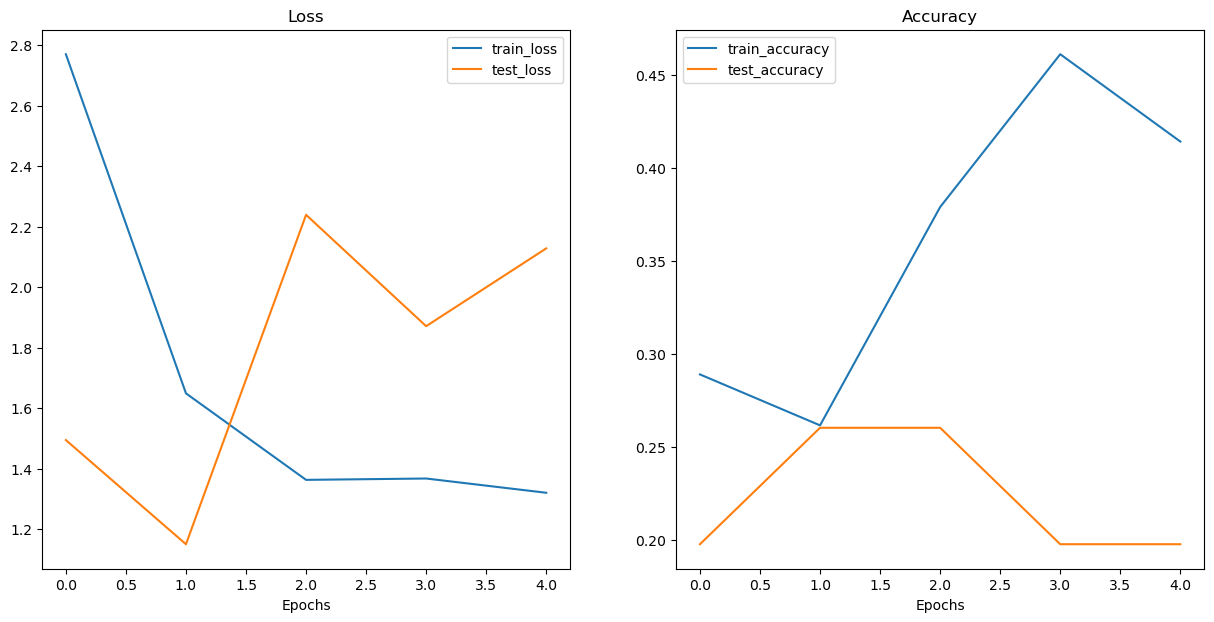

In [59]:
from helper_functions import plot_loss_curves
plot_loss_curves(results)

## Poor results -- What our training setup is missing?

#### Prevent under fitting
* Data - uses far less data

#### Prevent over fitting

* Gradient clipping - prevents gradients from getting too big
* Learning rate warmup - start with a low learning rate and increase to a base LR
* Learning rate decay - as model gets closer to convergence, start to lower the learning rate



## Using a pretrained ViT from `torchvision.models`

Generally, in deep learning we can use a pretrained model from a large dataset on our own problem, it's ofter a good place to start.

If we can find a pretrained model and use transfer learning, we should give it a go, it often achieves great results with little data.


In [60]:
# Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # 'DEFAULT' = best available

# Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights = pretrained_vit_weights).to(device)

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# Update the classifier head
torch.manual_seed(42)
torch.cuda.manual_seed(42)

pretrained_vit.heads = nn.Linear(in_features = 768,
                                out_features = len(class_names)).to(device)

In [61]:
# Get a summary using torchinfo.summary
summary(model = pretrained_vit,
       input_size = (1, 3, 224, 224), # (batch_size, number_of_patches, embedding_dimension)
       col_names = ["input_size", "output_size", "num_params", "trainable"],
       col_width = 20,
       row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### Preparing data for ViT model

When using a pretrained model, our data must be formatted the same way the model was trained on.

In [62]:
# Getting automatic transfroms from pretrained ViT weights
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [63]:
train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [65]:
# Setup dataloaders
from going_modular import data_setup
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                                                    test_dir = test_dir,
                                                                                                    train_transform = vit_transforms,
                                                                                                    test_transform = vit_transforms, 
                                                                                                    batch_size = 32)

### Training feature extractor ViT model

In [66]:
from going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params = pretrained_vit.parameters(),
                            lr = 1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of pretrained ViT
torch.manual_seed(42)
torch.cuda.manual_seed(42)

pretrained_vit_results = engine.train(model = pretrained_vit,
                                     train_dataloader = train_dataloader_pretrained,
                                     test_dataloader = test_dataloader_pretrained,
                                     optimizer = optimizer,
                                     loss_fn = loss_fn,
                                     epochs = 10,
                                     device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7665 | train_acc: 0.7227 | test_loss: 0.5432 | test_acc: 0.8665
Epoch: 2 | train_loss: 0.3428 | train_acc: 0.9453 | test_loss: 0.3263 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2064 | train_acc: 0.9531 | test_loss: 0.2707 | test_acc: 0.9081
Epoch: 4 | train_loss: 0.1556 | train_acc: 0.9570 | test_loss: 0.2422 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.1246 | train_acc: 0.9727 | test_loss: 0.2279 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1216 | train_acc: 0.9766 | test_loss: 0.2129 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0938 | train_acc: 0.9766 | test_loss: 0.2352 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0797 | train_acc: 0.9844 | test_loss: 0.2281 | test_acc: 0.8778
Epoch: 9 | train_loss: 0.1098 | train_acc: 0.9883 | test_loss: 0.2074 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0650 | train_acc: 0.9883 | test_loss: 0.1804 | test_acc: 0.9176


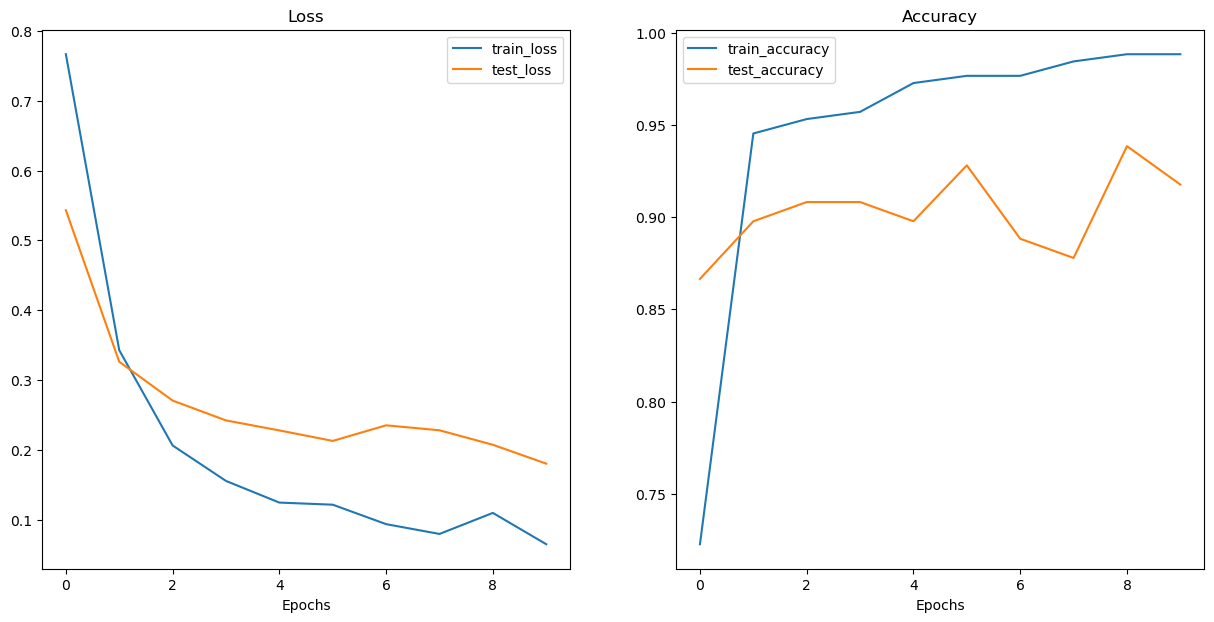

In [67]:
plot_loss_curves(pretrained_vit_results)

### Saving the best performing ViT model

We want to check the filesize because if we wanted to deploy a model to a site/ mobile application, we may have limilations on the size of the model we can deploy.

E.g a smaller model may be required due to compute restrictions


In [68]:
from going_modular import utils

utils.save_full_model(model = pretrained_vit,
                           target_dir = "models",
                           model_name = "full_model_pretrained_vit_feature_extractor_pizza_steak_sushi.pth"
                           )

[INFO] Saving model to: models\full_model_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [69]:
from pathlib import Path

# Get the model size in bytes and convert to megabytes
pretrained_vit_model_size = Path("models/pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024)

print(f"size of the model is {pretrained_vit_model_size} MB")

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'models\\pretrained_vit_feature_extractor_pizza_steak_sushi.pth'

### Predicting on a custom image

In [ ]:
data_path = Path("data/")

In [ ]:
# Download the image
import requests

# Setup custom image path
custom_image_path = data_path/"hidden_pizza.png"

# Download the image if it doesn't exist 
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        request = requests.get("https://github.com/aayush2058/pytorch_fundamentals/raw/main/data/hidden_pizza.png")
        print(f"Downloading {custom_image_path}.... ")
        f.write(request.content)
        print("successful")      
else:
    print(f"{custom_image_path} already exists, skipping download...")

In [ ]:
# Prediction
from going_modular.predictions import pred_and_plot_image
pred_and_plot_image(model = pretrained_vit,
                   image_path = custom_image_path,
                   class_names = class_names)